## Welcome to Hypothesis Test 2 part 2

I will be using the Northwind Traders Access database to perform a hypothesis test to answer the following question.  **_Is the company spending more on shipping each year?_**<br> 
**Null Hypothesis** <br>
An order is just as likely to cost the same to ship regardless of month <br>

**Alternative Hypothesis** <br>
The cost of the shipment is related to the month in which it is shipped<br>

**Variables We Are Interested in Determining the Relationship Between**<br>
The Month the order was shipped and the Cost of shipping the order. <br>

**alpha** 0.05<br>

**effect size** We will use Cohen's D to determine if the difference is large enough to worry about.  Cohen's d is determined by calculating the mean difference between the two groups, and then dividing the result by the pooled standard deviation.


###  Loading Libraries

In [1]:
# add every library I will use throughout the project here
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stat
from scipy import stats
from __future__ import print_function


#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#for t-tests
from scipy.stats import ttest_ind

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


### 1.2 Retrieve data from database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [3]:
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)


In [4]:
select SUM(transaction) as Price, 
       strftime("%m-%Y", transDate) as 'month-year' 
       from transaction group by strftime("%m-%Y", transDate);

SyntaxError: invalid syntax (<ipython-input-4-0b458dff2493>, line 1)

In [59]:
df = pd.read_sql_query('''
                    SELECT  ShippedDate, Freight
                    FROM [Order] 
                    ORDER BY ShippedDate
                    ''', conn)

In [60]:
df.dropna(inplace=True)

In [62]:
df.head()

,ShippedDate,Freight
21,2012-07-10,11.61
22,2012-07-11,51.30
23,2012-07-12,65.83
24,2012-07-15,41.34
25,2012-07-15,148.33


In [99]:
df['date'] =  pd.to_datetime(df['ShippedDate'], format='%Y-%m-%d')

KeyError: 'ShippedDate'

In [71]:
df.set_index('date', inplace=True)

In [75]:
df.drop(columns="ShippedDate", inplace=True)

In [76]:
df.head()

,Freight
date,
2012-07-10,11.61
2012-07-11,51.30
2012-07-12,65.83
2012-07-15,41.34
2012-07-15,148.33


In [80]:
df.columns= ['cost']

In [82]:
df.head()

,cost
date,
2012-07-10,11.61
2012-07-11,51.30
2012-07-12,65.83
2012-07-15,41.34
2012-07-15,148.33


In [83]:
# Use pandas grouper to group values using annual frequency
year_groups = df.groupby(pd.Grouper(freq ='A'))


In [84]:
#Create a new DataFrame and store yearly values in columns 
cost_annual = pd.DataFrame()

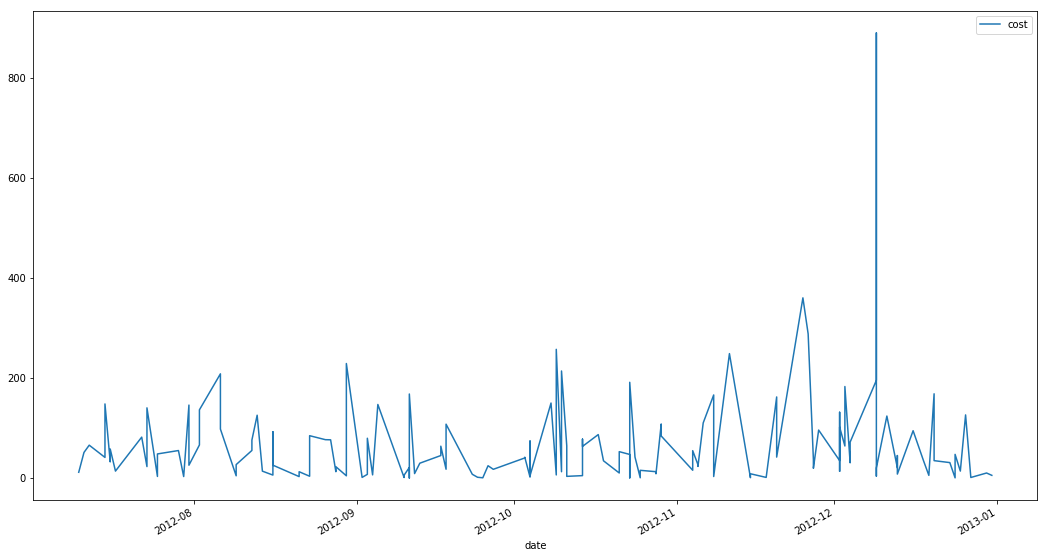

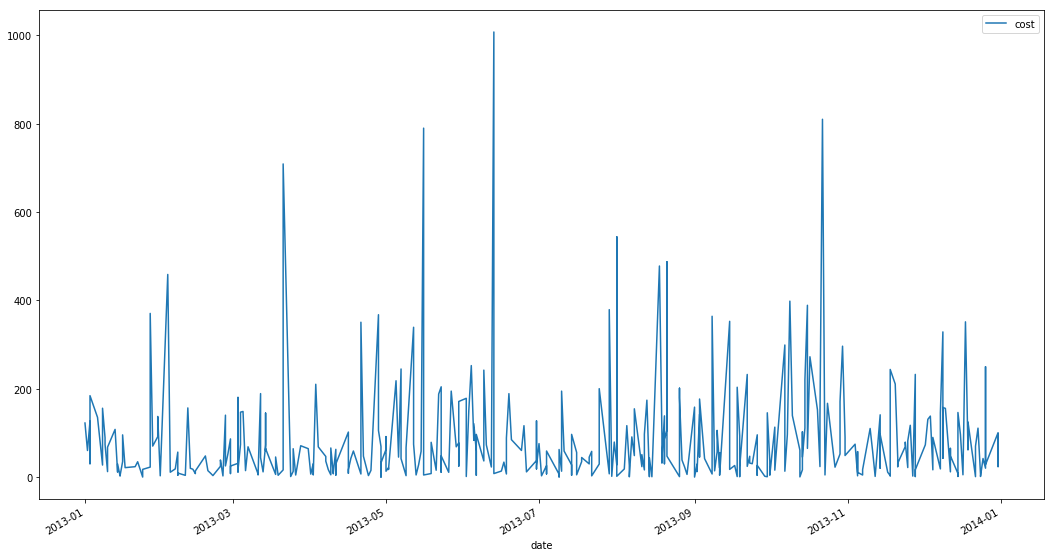

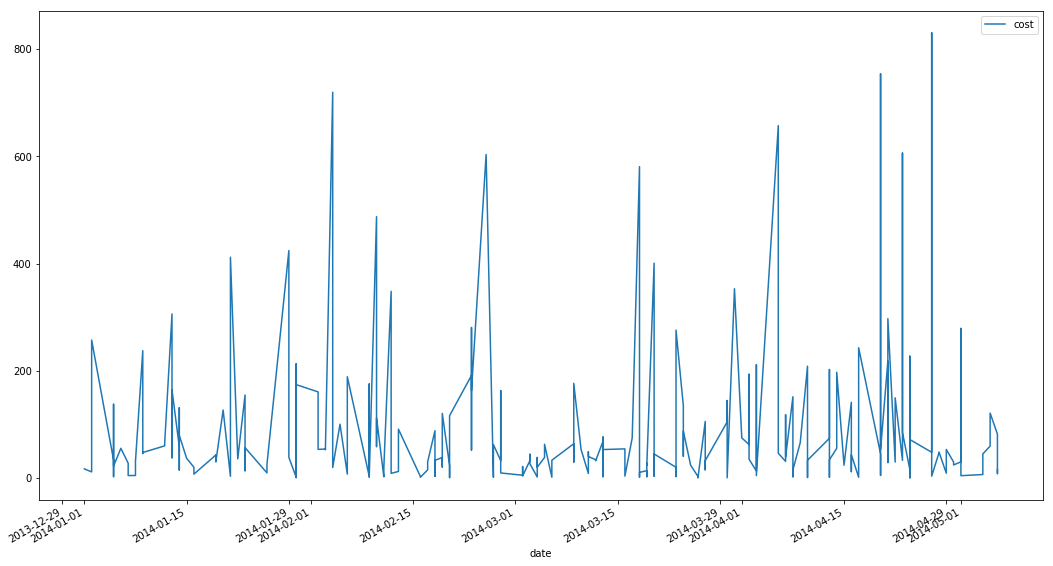

In [86]:
year_groups.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()

In [97]:
df.reset_index(inplace=True)
df.dropna(inplace=True)
df.head()

,index,date,cost
0,0,2012-07-10,11.61
1,1,2012-07-11,51.30
2,2,2012-07-12,65.83
3,3,2012-07-15,41.34
4,4,2012-07-15,148.33


/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


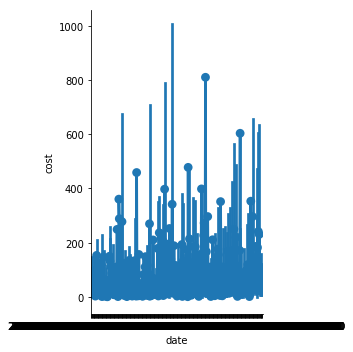

In [98]:
sns.tsplot(data=df, time="date", unit="country",
           condition="Income Level", value="HIV Rate")
plt.show()

In [ ]:
df = pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    ORDER BY ShippedDate
                    ''', conn)

### 2.2 Checking Assumptions

#### 2.2.1 Normality


In order to perform a two-sample t-test, there are several assumptions that need to be met, the first of which is normality. We will assess this visually and also perform a normality test using the [normaltest function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) which combines measures of skew and kurtosis.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.subplot(311)

sns.distplot(ctrl['Freight'], hist='density')
plt.title('2012 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.subplot(312)
sns.distplot(exp['Freight'], hist='density')
plt.title('2013-2014 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.subplot(313)
sns.distplot(exp['Freight'], hist='density')
plt.title('2013-2014 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
exp.dtypes

In [ ]:
# visual check for normality
plt.figure(figsize=(10, 5))
sns.distplot(ctrl["Freight"], label='Control')
sns.distplot(exp["Freight"], label='Experimental',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=15)
plt.xlabel('Quantity/Order', fontsize=15)
plt.legend(fontsize=15);

We can see that both the control and test data sets are skewed positive through visual inspection we will now check that observation using scipy's normal test function.

In [ ]:
# Use scipy's normal test function for both groups
import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(ctrl["Freight"]))
print('Normality of distribution: ', stat.normaltest(exp["Freight"]))

statistic = s^2 + k^2 = Skewness + Kurtosis  

In [ ]:
stat.skewtest(ctrl["Freight"]) 

In [ ]:
stat.kurtosistest(ctrl["Freight"])

If the visual was not obvious enough, such a low p-value result from the scipy.stats.normaltest results should remove all doubt.  The resulting distribution is non-normal.  The results of both the experimental and control groups are positively skewed.  We can still use this sample thanks to the **Central Limit Theorem**. 

#### 2.2.2 Independence

The next assumption is independence both within and between groups. This assumption is satisfied because we can be reasonably confident that a shipment from one year will have no affect on the cost of a shipment in another year. And one shipment is independent of another's within the same year.

#### 2.2.3 Random

The last assumption is that samples are randomly chosen, meaning every observation has an equal chance of being selected. When we create the sampling distribution of sample mean, we will use numpy's [random.choice function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) to ensure a random sample is generated.

### 2.3 Creating a Sampling Distribution of Sample Mean

In [ ]:
sample = ctrl["Freight"]+exp["Freight"]

In [ ]:
len(ctrl["Freight"])

In [ ]:
len(exp["Freight"])

In [ ]:
#taking a look at the means
print("control " + str(ctrl["Freight"].mean()))
print("experimental " + str(exp["Freight"].mean()))    

In [ ]:
original_diff = abs(ctrl["Freight"].mean()-exp["Freight"].mean())
original_diff

In [ ]:
#check the amount of samples and use 1/2
i = int(np.round(len(freight_total["Freight"])/2,0))
i 

In [ ]:
sample_a = freight_total["Freight"].sample(415)
sample_b = freight_total.drop(sample_a.index)["Freight"]

In [ ]:
sample_diff = np.mean(sample_a) - np.mean(sample_b)
abs(sample_diff)

In [ ]:
%%time
my_diffs = []
for i in range(10000):
    sample_a = freight_total["Freight"].sample(415)
    sample_b = freight_total.drop(sample_a.index)["Freight"]
    diff = np.mean(sample_a) - np.mean(sample_b)
    my_diffs.append(diff)

In [ ]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10,5))

plt.hist(my_diffs, color="orange", label="my_diffs")
plt.axvline(original_diff, color = 'k', linewidth = 5, label="original_diff")


plt.title("Sampling Distribution of Sample Mean")
plt.ylabel("Freight Costs")
plt.legend()
plt.show()

fig.savefig("my_diffs2.png", bbox_inches="tight")


In [ ]:
my_count = 0
for indv_diff in my_diffs:
    if indv_diff > original_diff:
        my_count += 1

In [ ]:
my_count/len(my_diffs)

##  Two Sample t-test

###  Hypotheses, Type 1 & Type 2 errors


The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in years

$H_a:$ Freight costs are different from year to year

We set the significance level ($\alpha$) to 0.05 or 5%. In other words, this is the $\alpha$ value we are comfortable with for making a Type I error which we consider to be more serious than a Type II error. It is important to identify these errors early on so we can improve the test design. <br>

We are attempting to minimize the probability of committing a Type I error by maximizing the power (probability of making the correct decision when $H_a$ is true). <br>

Type I error: is the rejection of a true null hypothesis.  For this experiment that means the test claims the null hypothesis 'There is no difference in years' is False, when in reality it is true.  This would result in the company adjusting their business model (perhaps raising prices, and losing customers) when no adjustment is in fact necessary. 

Type II error: is the acceptance of the null hypothesis 'There is no difference in years' when it is in reality False.   This could result in the imaginary business to not allocate their finances appropriately and perhaps not charging enough to account for shipping or too much and not keeping their prices as low as competition.



In [ ]:
ttest_ind(exp["Freight"].values, ctrl["Freight"].values )

**The 0.15 p-value shows there is not a statistically signifigant difference.  We have failed to reject the null hypothesis.**

In [ ]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

In [ ]:
ctrl_sample = create_sample_distribution(ctrl["Freight"])
exp_sample = create_sample_distribution(exp["Freight"])

In [ ]:
ttest_ind(exp["Freight"].values, ctrl["Freight"].values )

In [ ]:
# Calculate Sample Variance
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)

In [ ]:
# Calculate 2 sample t-statistc
def twosample_tstatistic(exp, ctrl):
    exp_mean, ctrl_mean = np.mean(exp), np.mean(ctrl)
    samp_var = sample_variance(exp, ctrl)
    n_e, n_c = len(exp), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(exp["Freight"], ctrl["Freight"])
t_stat

Given the above information we can calculate area under the curve to find p-value

In [ ]:
# Visualize test statistic

def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred', label="Probability Density Function")

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5, label= "T Stat")
    
    plt.legend(loc=1)
    plt.tight_layout()
    plt.show()
    return None

n_control = len(ctrl_sample)
n_experimental = len(exp_sample)
visualize_t(t_stat, n_control, n_experimental)

### 3.2 Welch's t-test

In [ ]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(ctrl["Freight"], exp["Freight"])

### 3.3 Effect Size

## Cohen's $d$

Cohen’s D is one of the most common ways to measure effect size.  As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

Cohen’s d is similar to the unpaired t test t value. It relies on Standard Deviations instead of Standard Errors

The basic formula to calculate Cohen’s $d$ is:

> ** $d$ = effect size (difference of means) / pooled standard deviation **

The denominator is the **standardiser**, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean). 

#### **other considerations for determining effect size** <br>
**Cohen's d** is the appropriate effect size measure if two groups have similar standard deviations and are of the same size. **Glass' delta**, which uses only the standard deviation of the control group, is an alternative measure if each group has a different standard deviation. **Hedges' g**, which provides a measure of effect size weighted according to the relative size of each sample, is an alternative where there are different sample sizes.

In [ ]:
from IPython.display import Image
Image("Cohen_Glass_Hedge.jpg")

In [ ]:
len(ctrl_sample)

In [ ]:
len(exp_sample)

In [ ]:
np.mean(ctrl_sample)

In [ ]:
np.std(ctrl_sample)

In [ ]:
np.std(exp_sample)

In [ ]:
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
ctrl_sample = np.array(ctrl_sample)
exp_sample = np.array(exp_sample)

The denominator of the equation is the standardiser and, it is important to select the most appropriate standardiser for a given dataset because it can have a big influence on Cohen’s d.

In [ ]:
abs(Cohen_d(ctrl_sample,exp_sample))

In [ ]:
def Glass(group1, group2):
    # Compute Glass's delta.
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d



parameters 
small effect = 0 to .2 std 
med. effect = .2 to .8 std 
large effect > .8 std 

Our Cohen's d value is 3.08; therefore we would categorize the difference as a large effect size. **However**, we have already determined that there is not a significant difference between the years.<br>

I will use **Glass's Delta** to check the effect size.  Which is similar to Cohen's D but it uses only the control groups standard deviation not the pooled standard deviation.  

```If the standard deviations of the two groups differ, then the homogeneity of variance assumption is violated and pooling the standard deviations is not appropriate. One solution is to insert the standard deviation of the control group into the equation and calculate Glass's delta (Glass et al. 1981, p.29). The logic is that the standard deviation of the control group is untainted by the effects of the treatment and will therefore more closely reflect the population standard deviation. The strength of this assumption is directly proportional to the size of the control group. The larger the control group, the more it is likely to resemble the population from which it was drawn.``` [polyu.edu.hk](http://www.polyu.edu.hk/mm/effectsizefaqs/effect_size_equations2.html)

Cohen's d = (81.82788 - 66.245) ⁄ 4.994709 = 3.119877.

Gates' delta = (81.82788 - 66.245) ⁄ 4.333427 = 3.595972.

Hedges' g = (81.82788 - 66.245) ⁄ 4.994709 = 3.119877

### 3.4 ANOVA

In [ ]:
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)


In [ ]:
df = pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order]
                    Where ShippedDate IS NOT NULL
                    ORDER BY ShippedDate
                    ''', conn)

In [ ]:
df.head()

In [ ]:
import datetime as dt

In [ ]:
df['ShippedDate'] =  pd.to_datetime(df['ShippedDate'],
                              format='%Y-%m-%d')

In [ ]:
df.head()

In [ ]:
df['Year'] = df['ShippedDate'].dt.strftime('%Y')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((3,7))
sns.boxplot(x='Year',y='Freight',data=df,ax=ax)


plt.show()



In [ ]:
# wrap with C() to indicate categorical variable
results = ols('Freight ~ C(Year)', data=df).fit()

In [ ]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

In [ ]:
mc = MultiComparison(df['Freight'], df['Year'])
mc_results = mc.tukeyhsd()
print(mc_results)

mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()
mc_results.savefig("mc_results2.png", bbox_inches='tight')

Unable to reject null hypothesis.  There is not a statistically significant correlation between the year and freight cost.